In [1]:
# Клонируем репозиторий и переходим в папку проекта
!git clone https://github.com/dejar212/Diffraction.git
%cd Diffraction


Cloning into 'Diffraction'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 146 (delta 42), reused 81 (delta 31), pack-reused 44 (from 1)
Receiving objects: 100% (146/146), 752.77 KiB | 3.36 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/Diffraction


: 

: 

: 

: 

: 

In [2]:
%cd /content/Diffraction
!sudo apt-get update
!sudo apt-get install -y build-essential ninja-build

/content/Diffraction
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:5 https://cli.github.com/packages stable/main amd64 Packages [345 B]       
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,205 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,858 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]       
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,205 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/p

In [3]:
# Проверим среду выполнения и наличие GPU
import torch
print('GPU доступен:', torch.cuda.is_available())
!nvidia-smi || echo "GPU не обнаружен! Проверьте настройки среды выполнения."


GPU доступен: True
Sat Dec 20 06:14:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

## Настройка параметров CPU/CUDA решателей

Ниже можно выбрать значения `a`, `b`, `λ`, угла `θ`, числа коэффициентов `N` и глубины скин-слоя `δ`, которые будут прошиты в исходники `cpp_version/src/main.cpp` и `cuda_version/src/main.cu` перед сборкой. После изменения не забудьте повторно пересобрать нужную часть проекта, чтобы новые параметры попали в бинарники.


In [4]:
# Виджет для выбора коэффициентов
import json
import math
import re
import subprocess
import sys
from pathlib import Path
from IPython.display import Markdown, display

try:
    import ipywidgets as widgets
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ipywidgets"])
    import ipywidgets as widgets


def _resolve_repo_root() -> Path:
    cwd = Path.cwd()
    if (cwd / "cpp_version").exists():
        return cwd
    alt_root = Path("/content/Diffraction")
    if alt_root.exists():
        return alt_root.resolve()
    return cwd


def _config_path(repo_root: Path) -> Path:
    content_root = Path("/content")
    if content_root.exists():
        return (content_root / "diffraction_params.json")
    return repo_root / "notebook_params.json"


def _ensure_angles(params: dict) -> dict:
    params = params.copy()
    if "theta_deg" not in params and "theta_rad" in params:
        params["theta_deg"] = math.degrees(params["theta_rad"])
    if "theta_rad" not in params:
        params["theta_rad"] = math.radians(params.get("theta_deg", 45.0))
    return params


def _fmt(value: float) -> str:
    return f"{value:.12g}"


def _update_source(path: Path, params: dict):
    pattern_map = [
        (r"const double a = [^;]+;", lambda p: f"const double a = {_fmt(p['a'])};"),
        (r"const double b = [^;]+;", lambda p: f"const double b = {_fmt(p['b'])};"),
        (r"const double lambda = [^;]+;", lambda p: f"const double lambda = {_fmt(p['lambda'])};"),
        (r"const double theta = [^;]+;", lambda p: f"const double theta = {_fmt(p['theta_rad'])};"),
        (r"const int N_default = [^;]+;", lambda p: f"const int N_default = {int(p['N'])};"),
        (r"const double skinDepth = [^;]+;", lambda p: f"const double skinDepth = {_fmt(p['delta'])};"),
    ]
    text = path.read_text()
    for pattern, repl_factory in pattern_map:
        text, count = re.subn(pattern, repl_factory(params), text, count=1)
        if count == 0:
            raise RuntimeError(f"Не удалось обновить {pattern} в {path}")
    path.write_text(text)


REPO_ROOT = _resolve_repo_root()
CONFIG_PATH = _config_path(REPO_ROOT)
DEFAULT_PARAMS = {
    "a": -1.0,
    "b": 1.0,
    "lambda": 1.0,
    "theta_deg": 45.0,
    "theta_rad": math.radians(45.0),
    "N": 10,
    "delta": 0.1,
}
params_state = _ensure_angles(DEFAULT_PARAMS)

if CONFIG_PATH.exists():
    try:
        loaded = json.loads(CONFIG_PATH.read_text())
        params_state.update(_ensure_angles(loaded))
    except Exception as exc:
        print("⚠️ Не удалось загрузить сохранённые параметры:", exc)

float_opts = dict(layout=widgets.Layout(width="220px"))
a_widget = widgets.FloatText(value=params_state["a"], description="a", **float_opts)
b_widget = widgets.FloatText(value=params_state["b"], description="b", **float_opts)
lambda_widget = widgets.FloatText(value=params_state["lambda"], description="λ", **float_opts)
theta_widget = widgets.FloatSlider(value=params_state["theta_deg"], min=0.0, max=85.0, step=0.5, description="θ (°)", readout_format=".1f")
N_widget = widgets.IntSlider(value=params_state["N"], min=4, max=200, step=2, description="N")
delta_widget = widgets.FloatText(value=params_state["delta"], description="δ", **float_opts)
apply_button = widgets.Button(description="Применить параметры", button_style="success")
status = widgets.Output()


def apply_params(_=None):
    params_state.update(
        _ensure_angles(
            {
                "a": float(a_widget.value),
                "b": float(b_widget.value),
                "lambda": float(lambda_widget.value),
                "theta_deg": float(theta_widget.value),
                "N": int(N_widget.value),
                "delta": float(delta_widget.value),
            }
        )
    )

    for rel in ("cpp_version/src/main.cpp", "cuda_version/src/main.cu"):
        _update_source(REPO_ROOT / rel, params_state)

    CONFIG_PATH.write_text(json.dumps(params_state, indent=2, ensure_ascii=False))

    with status:
        status.clear_output()
        display(Markdown(
            """**Параметры обновлены.**\\
a = {a:.3f}, b = {b:.3f}, λ = {lambda:.3f}, θ = {theta_deg:.1f}°, N = {N}, δ = {delta:.3f}""".format(**params_state)
        ))


def display_widget():
    info_label = widgets.HTML(value=f"<code>{CONFIG_PATH}</code>")
    return widgets.VBox([
        widgets.HBox([a_widget, b_widget, lambda_widget]),
        widgets.HBox([theta_widget, N_widget, delta_widget]),
        apply_button,
        status,
        widgets.HBox([widgets.Label("Config path:"), info_label]),
    ])

apply_button.on_click(apply_params)
display_widget()


In [5]:
# Вставка ключевых участков исходников
from pathlib import Path
from IPython.display import Code, Markdown, display

REPO_ROOT = Path.cwd()
if not (REPO_ROOT / "cpp_version").exists():
    alt_root = Path("/content/Diffraction")
    if alt_root.exists():
        REPO_ROOT = alt_root.resolve()

sections = [
    {
        "title": "CPU: DifrOnLenta::SolveDifr()",
        "path": REPO_ROOT / "cpp_version/src/DifrOnLenta.cpp",
        "anchors": ["int DifrOnLenta::SolveDifr", "bool DifrOnLenta::SolveDifr"],
        "length": 160,
        "lang": "cpp",
    },
    {
        "title": "CPU: Гауссово решение матрицы",
        "path": REPO_ROOT / "cpp_version/src/Gauss.cpp",
        "anchors": ["int Gauss(", "bool CGauss::Solve"],
        "length": 140,
        "lang": "cpp",
    },
    {
        "title": "CUDA: DifrOnLentaCuda::SolveDifr()",
        "path": REPO_ROOT / "cuda_version/src/DifrOnLentaCuda.cu",
        "anchors": ["int DifrOnLentaCuda::SolveDifr", "bool DifrOnLentaCuda::SolveDifr"],
        "length": 160,
        "lang": "cuda",
    },
]


def _extract_snippet(path: Path, anchors, length: int) -> str:
    lines = path.read_text().splitlines()
    for anchor in anchors:
        for idx, line in enumerate(lines):
            if anchor in line:
                start = idx
                end = min(len(lines), idx + length)
                return "\n".join(lines[start:end])
    raise ValueError(f"Не найден ни один из якорей {anchors} в {path}")

for section in sections:
    try:
        snippet = _extract_snippet(section["path"], section["anchors"], section["length"])
    except ValueError as exc:
        display(Markdown(f"⚠️ {exc}"))
        continue
    display(Markdown(f"### {section['title']} ({section['path'].relative_to(REPO_ROOT)})"))
    display(Code(snippet, language=section["lang"]))


### CPU: DifrOnLenta::SolveDifr() (cpp_version/src/DifrOnLenta.cpp)

int DifrOnLenta::SolveDifr() {
    using namespace std::chrono;
    
    auto totalStart = high_resolution_clock::now();
    
    CVect B(N);
    CMatr A(N);
    
    // Вычисление точек коллокации (узлы квадратуры Гаусса-Чебышева)
    std::vector<double> x_points(M);
    for (int m = 0; m < M; m++) {
        x_points[m] = (b - a) / 2.0 * std::cos((2 * m + 1) / 2.0 / M * M_PI) + (b + a) / 2.0;
    }
    
    // ========== ПОСТРОЕНИЕ МАТРИЦЫ ==========
    auto matrixStart = high_resolution_clock::now();
    
    for (int k = 0; k < N; k++) {
        // Построение строки матрицы
        for (int j = 0; j < N; j++) {
            Complex s(0.0, 0.0);
            for (int m = 0; m < M; m++) {
                for (int n = 0; n < M; n++) {
                    s += r(x_points[n], x_points[m]) * ChebAB(j, x_points[n]) * ChebAB(k, x_points[m]);
                }
            }
            s *= M_PI * M_PI / (M * M);
            A[k][j] = s;
        }
        
        // Построение вектора правой части
        Complex s(0.0, 0.0);
        for (int m = 0; m < M; m++) {
            s += f(x_points[m]) * ChebAB(k, x_points[m]);
        }
        B[k] = s * M_PI / static_cast<double>(M);
        
        // Диагональные элементы с учетом регуляризации
        Complex regularization;
        if (k == 0) {
            regularization = Complex(M_PI * M_PI * std::log(b - a), 0.0);
        } else {
            regularization = Complex(M_PI * M_PI / 2.0 / (k + 1), 0.0);
        }
        
        A[k][k] = A[k][k] + regularization;
        
        // Граничное условие Леонтовича для импедансной поверхности
        if (skinDepth > 0.0) {
            Complex impedanceCorrection = ci * chi * A[k][k];
            A[k][k] = A[k][k] + impedanceCorrection;
        }
    }
    
    auto matrixEnd = high_resolution_clock::now();
    lastTiming.matrixBuildTime = duration_cast<microseconds>(matrixEnd - matrixStart).count() / 1000.0;
    
    // ========== РЕШЕНИЕ СЛАУ ==========
    auto solveStart = high_resolution_clock::now();
    
    CVect w(N);
    int output = Gauss(A, B, w);
    
    auto solveEnd = high_resolution_clock::now();
    lastTiming.solveTime = duration_cast<microseconds>(solveEnd - solveStart).count() / 1000.0;
    
    auto totalEnd = high_resolution_clock::now();
    lastTiming.totalTime = duration_cast<microseconds>(totalEnd - totalStart).count() / 1000.0;
    
    // Копирование результата
    for (int k = 0; k < N; k++) {
        y[k] = w[k];
    }
    
    return output;
}

### CPU: Гауссово решение матрицы (cpp_version/src/Gauss.cpp)

int Gauss(CMatr& A, CVect& b, CVect& x) {
    int N = b.Size();
    
    // Прямой ход метода Гаусса
    for (int i = 0; i < N - 1; i++) {
        // Поиск главного элемента
        double max = std::abs(A[i][i]);
        int maxN = i;
        
        for (int k = i + 1; k < N; k++) {
            double ss = std::abs(A[k][i]);
            if (ss > max) {
                max = ss;
                maxN = k;
            }
        }
        
        // Перестановка строк
        if (maxN != i) {
            for (int k = 0; k < N; k++) {
                Complex s1 = A[i][k];
                A[i][k] = A[maxN][k];
                A[maxN][k] = s1;
            }
            Complex s1 = b[i];
            b[i] = b[maxN];
            b[maxN] = s1;
        }
        
        // Проверка на малость диагонального элемента
        Complex s = 1.0 / A[i][i];
        if (std::abs(s) < 1e-12) {
            return -1;
        }
        
        // Исключение переменной
        for (int j = i + 1; j < N; j++) {
            Complex s1 = A[j][i] * s;
            for (int k = i + 1; k < N; k++) {
                A[j][k] = A[j][k] - s1 * A[i][k];
            }
            b[j] = b[j] - b[i] * s1;
        }
    }
    
    // Проверка последнего диагонального элемента
    if (std::abs(A[N - 1][N - 1]) < 1e-12) {
        return -1;
    }
    
    // Обратный ход метода Гаусса
    x[N - 1] = b[N - 1] / A[N - 1][N - 1];
    
    for (int i = N - 2; i >= 0; i--) {
        Complex s = b[i];
        for (int j = N - 1; j > i; j--) {
            s = s - A[i][j] * x[j];
        }
        x[i] = s / A[i][i];
    }
    
    return 1;
}

### CUDA: DifrOnLentaCuda::SolveDifr() (cuda_version/src/DifrOnLentaCuda.cu)

int DifrOnLentaCuda::SolveDifr() {
    using clock = std::chrono::high_resolution_clock;
    auto totalStart = clock::now();

    const int quadPoints = M;
    std::vector<double> xPoints(quadPoints);
    for (int m = 0; m < quadPoints; m++) {
        xPoints[m] = (b - a) / 2.0 * cos((2 * m + 1) / 2.0 / quadPoints * M_PI) + (b + a) / 2.0;
    }

    size_t matrixSize = static_cast<size_t>(N) * N;
    
    double* d_xPoints = nullptr;
    Complex* d_matrix = nullptr;
    Complex* d_rhs = nullptr;
    int* d_ipiv = nullptr;
    int* d_info = nullptr;

    CheckCuda(cudaMalloc(&d_xPoints, sizeof(double) * quadPoints), "cudaMalloc xPoints");
    CheckCuda(cudaMalloc(&d_matrix, sizeof(Complex) * matrixSize), "cudaMalloc matrix");
    CheckCuda(cudaMalloc(&d_rhs, sizeof(Complex) * N), "cudaMalloc rhs");
    CheckCuda(cudaMalloc(&d_ipiv, sizeof(int) * N), "cudaMalloc ipiv");
    CheckCuda(cudaMalloc(&d_info, sizeof(int)), "cudaMalloc info");

    CheckCuda(cudaMemcpy(d_xPoints, xPoints.data(), sizeof(double) * quadPoints, cudaMemcpyHostToDevice), "cudaMemcpy xPoints");

    DeviceParams params{a, b, lambda, theta, skinDepth, chi, N};

    // --- MATRIX BUILD ---
    cudaEvent_t matrixStart, matrixEnd;
    CheckCuda(cudaEventCreate(&matrixStart), "cudaEventCreate matrixStart");
    CheckCuda(cudaEventCreate(&matrixEnd), "cudaEventCreate matrixEnd");
    CheckCuda(cudaEventRecord(matrixStart), "cudaEventRecord matrixStart");

    dim3 block(16, 16);
    dim3 grid((N + block.x - 1) / block.x, (N + block.y - 1) / block.y);
    BuildMatrixKernel<<<grid, block>>>(d_matrix, d_xPoints, params, quadPoints);
    CheckCuda(cudaGetLastError(), "BuildMatrixKernel launch");

    dim3 rhsBlock(256);
    dim3 rhsGrid((N + rhsBlock.x - 1) / rhsBlock.x);
    BuildRhsKernel<<<rhsGrid, rhsBlock>>>(d_rhs, d_xPoints, params, quadPoints);
    CheckCuda(cudaGetLastError(), "BuildRhsKernel launch");

    CheckCuda(cudaEventRecord(matrixEnd), "cudaEventRecord matrixEnd");
    CheckCuda(cudaEventSynchronize(matrixEnd), "cudaEventSynchronize matrixEnd");

    float matrixMs = 0.0f;
    CheckCuda(cudaEventElapsedTime(&matrixMs, matrixStart, matrixEnd), "cudaEventElapsedTime");
    lastTiming.matrixBuildTime = matrixMs;

    // --- SOLVE WITH cuSOLVER ---
    auto solveStart = clock::now();
    
    cusolverDnHandle_t cusolverH = nullptr;
    CheckCusolver(cusolverDnCreate(&cusolverH), "cusolverDnCreate");

    int workSize = 0;
    // Calculate workspace size for Zgetrf
    CheckCusolver(cusolverDnZgetrf_bufferSize(
        cusolverH,
        N,
        N,
        reinterpret_cast<cuDoubleComplex*>(d_matrix),
        N, // LDA
        &workSize
    ), "cusolverDnZgetrf_bufferSize");

    Complex* d_work = nullptr;
    CheckCuda(cudaMalloc(&d_work, sizeof(Complex) * workSize), "cudaMalloc work");

    // LU Factorization
    CheckCusolver(cusolverDnZgetrf(
        cusolverH,
        N,
        N,
        reinterpret_cast<cuDoubleComplex*>(d_matrix),
        N,
        reinterpret_cast<cuDoubleComplex*>(d_work),
        d_ipiv,
        d_info
    ), "cusolverDnZgetrf");

    // Check for singularity
    int h_info = 0;
    CheckCuda(cudaMemcpy(&h_info, d_info, sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy info");
    if (h_info != 0) {
        // Cleanup
        cudaFree(d_xPoints); cudaFree(d_matrix); cudaFree(d_rhs); 
        cudaFree(d_ipiv); cudaFree(d_info); cudaFree(d_work);
        cusolverDnDestroy(cusolverH);
        return -1; // Singular or Error
    }

    // Solve A * x = b (Result stored in d_rhs)
    CheckCusolver(cusolverDnZgetrs(
        cusolverH,
        CUBLAS_OP_N, // No transpose (A is already factorized)
        N,
        1, // nrhs
        reinterpret_cast<cuDoubleComplex*>(d_matrix),
        N, // LDA
        d_ipiv,
        reinterpret_cast<cuDoubleComplex*>(d_rhs),
        N, // LDB
        d_info
    ), "cusolverDnZgetrs");

    auto solveEnd = clock::now();
    lastTiming.solveTime = std::chrono::duration_cast<std::chrono::microse

In [6]:
# Собираем и запускаем только CUDA-версию (выводит CSV)
!bash cuda_version/colab/build_cuda.sh




-- The CXX compiler identification is GNU 11.4.0
-- The CUDA compiler identification is NVIDIA 12.5.82 with host compiler GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- Found CUDAToolkit: /usr/local/cuda/targets/x86_64-linux/include (found version "12.5.82")
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE
-- Configuring done (3.4s)
-- Generating done (0.0s)
-- Build files have been written to: /content/Diffraction/cuda_version/build
[ 25%] Building CUDA object CMakeFiles/CudaDiffr.dir/src/main.cu.o
[ 25%] Building CUDA 

In [7]:
%cd /content
!if [ -d Diffraction ]; then rm -rf Diffraction; fi
!git clone https://github.com/dejar212/Diffraction.git
%cd Diffraction
!python cuda_version/colab/run_benchmark.py

/content
Cloning into 'Diffraction'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 146 (delta 42), reused 81 (delta 31), pack-reused 44 (from 1)
Receiving objects: 100% (146/146), 752.77 KiB | 3.14 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/Diffraction
Проверка наличия CMake/compilers...

[cmd] cmake --version
cmake version 3.31.10

CMake suite maintained and supported by Kitware (kitware.com/cmake).

Установка python-библиотек для графиков...

[cmd] /usr/bin/python3 -m pip install --quiet matplotlib pandas numpy


[cmd] nvidia-smi
Sat Dec 20 06:14:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Pe

In [ ]:
# Синхронизация исходников с сохранёнными параметрами (запускайте после повторного клонирования)
import json
import math
import re
from pathlib import Path


def _resolve_repo_root() -> Path:
    cwd = Path.cwd()
    if (cwd / "cpp_version").exists():
        return cwd
    alt_root = Path("/content/Diffraction")
    if alt_root.exists():
        return alt_root.resolve()
    return cwd


def _config_path(repo_root: Path) -> Path:
    content_root = Path("/content")
    if content_root.exists():
        return content_root / "diffraction_params.json"
    return repo_root / "notebook_params.json"


def _ensure_angles(params: dict) -> dict:
    params = params.copy()
    if "theta_deg" not in params and "theta_rad" in params:
        params["theta_deg"] = math.degrees(params["theta_rad"])
    if "theta_rad" not in params:
        params["theta_rad"] = math.radians(params.get("theta_deg", 45.0))
    return params


def _fmt(value: float) -> str:
    return f"{value:.12g}"


def _update_source(path: Path, params: dict):
    pattern_map = [
        (r"const double a = [^;]+;", lambda p: f"const double a = {_fmt(p['a'])};"),
        (r"const double b = [^;]+;", lambda p: f"const double b = {_fmt(p['b'])};"),
        (r"const double lambda = [^;]+;", lambda p: f"const double lambda = {_fmt(p['lambda'])};"),
        (r"const double theta = [^;]+;", lambda p: f"const double theta = {_fmt(p['theta_rad'])};"),
        (r"const int N_default = [^;]+;", lambda p: f"const int N_default = {int(p['N'])};"),
        (r"const double skinDepth = [^;]+;", lambda p: f"const double skinDepth = {_fmt(p['delta'])};"),
    ]
    text = path.read_text()
    for pattern, repl_factory in pattern_map:
        text, count = re.subn(pattern, repl_factory(params), text, count=1)
        if count == 0:
            raise RuntimeError(f"Не удалось обновить {pattern} в {path}")
    path.write_text(text)


REPO_ROOT = _resolve_repo_root()
CONFIG_PATH = _config_path(REPO_ROOT)
if not CONFIG_PATH.exists():
    print("Сохранённые параметры не найдены — используются значения по умолчанию.")
else:
    params = _ensure_angles(json.loads(CONFIG_PATH.read_text()))
    for rel in ("cpp_version/src/main.cpp", "cuda_version/src/main.cu"):
        _update_source(REPO_ROOT / rel, params)
    print(f"Параметры из {CONFIG_PATH} применены к исходникам {REPO_ROOT}")


Сохранённые параметры не найдены — используются значения по умолчанию.


In [9]:
%cd /content/Diffraction
!cmake -S cpp_version -B cpp_version/build_colab -G Ninja -DCMAKE_BUILD_TYPE=Release
!cmake --build cpp_version/build_colab --config Release
!cpp_version/build_colab/diffraction_solver > cpu_output.txt
!cat cpu_output.txt

/content/Diffraction
-- C++ Standard: 17
-- Compiler: GNU
-- Build type: Release
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /content/Diffraction/cpp_version/build_colab
ninja: no work to do.

Решатель дифракции на ленте (CPU)

--- Случай 1: Идеальный проводник (без скин-эффекта) ---

Параметры:
a = -1, b = 1
λ = 1, θ = 45°
N = 10, δ = 0

Импедансный коэффициент χ: 0.000000 + 0.000000i

Коэффициенты Чебышева (10 шт):
#     Значение              
1     0.6041+-0.1112i
2     -0.6467+1.2332i
3     0.0500+4.5450i
4     -3.7178+3.1097i
5     -1.5492+-3.6432i
6     1.7386+0.1229i
7     -0.1923+1.3650i
8     -0.4504+-0.1659i
9     0.0862+-0.2437i
10    0.0631+0.0268i

Время выполнения:
Построение матрицы: 5.853 мс
Решение СЛАУ: 0.011 мс
Общее: 5.878 мс

--- Случай 2: С учетом скин-эффекта (delta = 0.100) ---

Параметры:
a = -1.000, b = 1.000
λ = 1.000, θ = 45.000°
N = 10, δ = 0.100

Импедансный коэффициент χ: 0.628319 + 0.628319i

Коэффициенты Чеб

In [10]:
!cmake -S cuda_version -B cuda_version/build -G Ninja -DCMAKE_BUILD_TYPE=Release -DCMAKE_CUDA_ARCHITECTURES=75
!cmake --build cuda_version/build --config Release
!cuda_version/build/CudaDiffr > cuda_output.txt
!cat cuda_output.txt
!python cuda_version/colab/run_benchmark.py

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /content/Diffraction/cuda_version/build
ninja: no work to do.

CUDA решатель дифракции на ленте

--- Случай 1: Идеальный проводник (без скин-эффекта) ---

Параметры:
a = -1, b = 1
λ = 1, θ = 45°
N = 10, δ = 0

Импедансный коэффициент χ: 0.000000 + 0.000000i

Коэффициенты Чебышева (10 шт):
#     Значение              
1     0.6041 + -0.1112i
2     -0.6467 + 1.2332i
3     0.0499 + 4.5451i
4     -3.7179 + 3.1097i
5     -1.5491 + -3.6433i
6     1.7385 + 0.1229i
7     -0.1922 + 1.3649i
8     -0.4506 + -0.1659i
9     0.0864 + -0.2439i
10    0.0629 + 0.0268i

Время выполнения:
Построение матрицы (GPU): 33.955 мс
Решение СЛАУ (GPU cuSOLVER): 28.720 мс
Общее: 165.180 мс

--- Случай 2: С учетом скин-эффекта (delta = 0.100) ---

Параметры:
a = -1.000, b = 1.000
λ = 1.000, θ = 45.000°
N = 10, δ = 0.100

Импедансный коэффициент χ: 0.628319 + 0.628319i

Коэффициенты Чебышева (10 шт):
#     Значение             

Доступные графики: ['combined_results.csv', 'speedup_n.png', 'matrix_n_compare.png', 'matrix_m_compare.png', 'combined_results_m.csv', 'speedup_m.png']


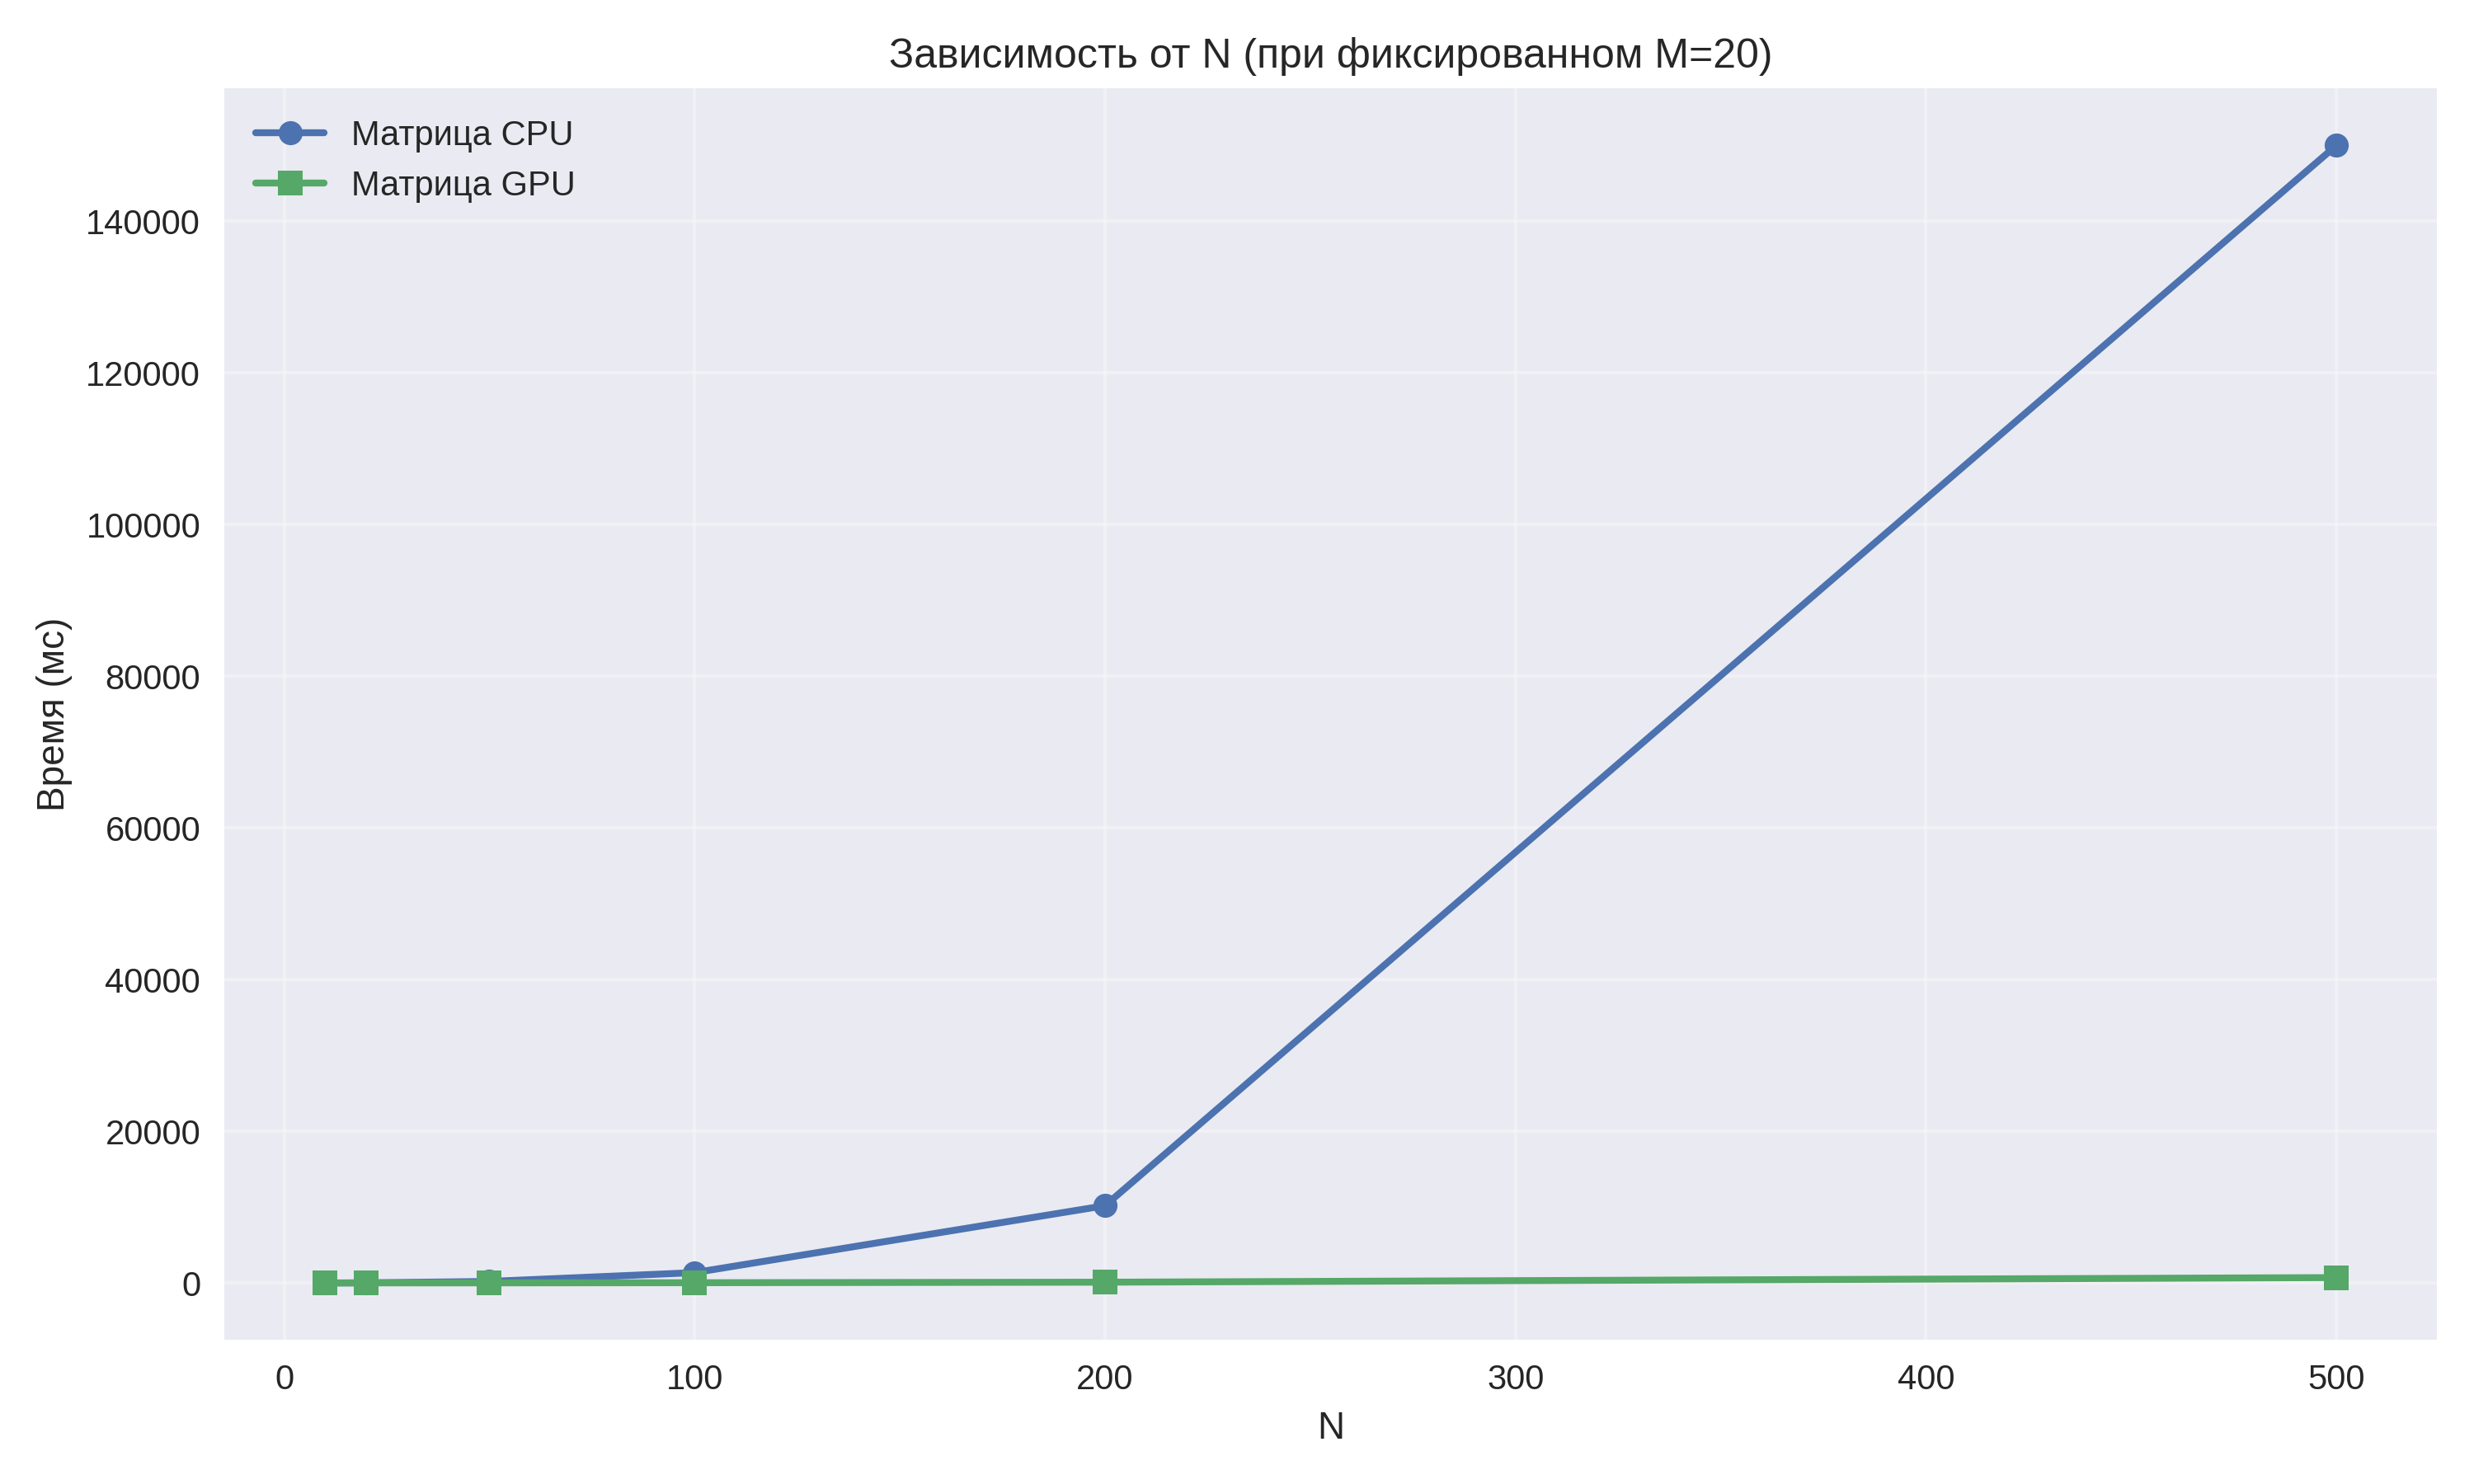

In [11]:
# Показывает пути к результатам и графикам
import os
from IPython.display import Image, display

plots_path = 'cuda_version/plots'
if os.path.exists(plots_path):
    print("Доступные графики:", os.listdir(plots_path))
    # Покажем основной график по N
    img_path = os.path.join(plots_path, 'matrix_n_compare.png')
    if os.path.exists(img_path):
        display(Image(img_path))
else:
    print("Папка с графиками не найдена.")

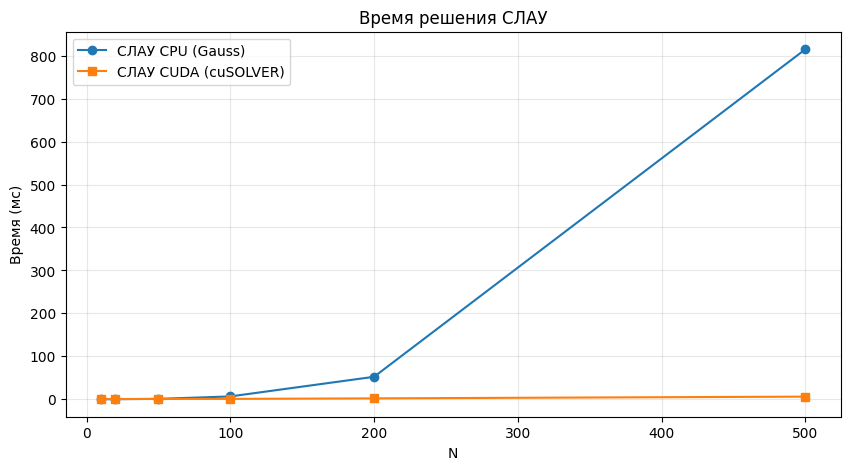

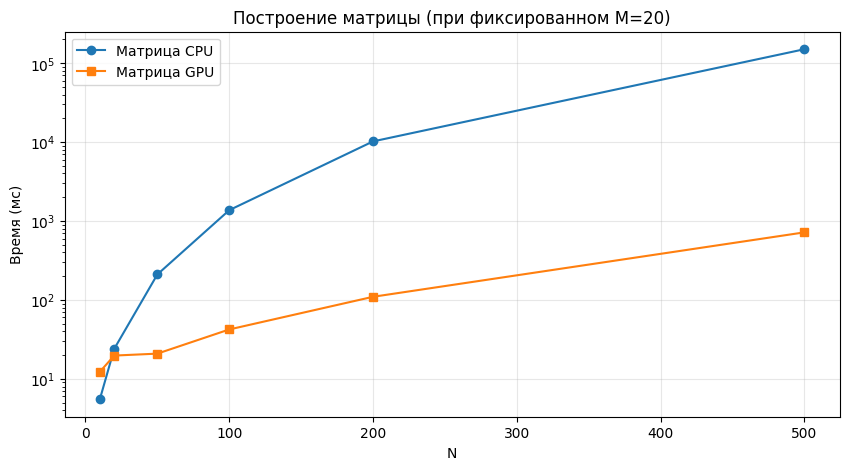

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os

results_path = 'cuda_version/plots/combined_results.csv'
if os.path.exists(results_path):
    df = pd.read_csv(results_path)
    
    # 1. Сравнение СЛАУ
    plt.figure(figsize=(10, 5))
    plt.plot(df['N'], df['SolveTime_ms_CPU'], 'o-', label='СЛАУ CPU (Gauss)')
    plt.plot(df['N'], df['SolveTime_ms_CUDA'], 's-', label='СЛАУ CUDA (cuSOLVER)')
    plt.xlabel("N")
    plt.ylabel("Время (мс)")
    plt.title("Время решения СЛАУ")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # 2. Сравнение матрицы (Зависимость от N)
    plt.figure(figsize=(10, 5))
    plt.plot(df['N'], df['MatrixTime_ms_CPU'], 'o-', label='Матрица CPU')
    plt.plot(df['N'], df['MatrixGPU_ms_CUDA'], 's-', label='Матрица GPU')
    plt.xlabel("N")
    plt.ylabel("Время (мс)")
    plt.title("Построение матрицы (при фиксированном M=20)")
    plt.yscale('log')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("Файл результатов не найден. Сначала запустите бенчмарк.")

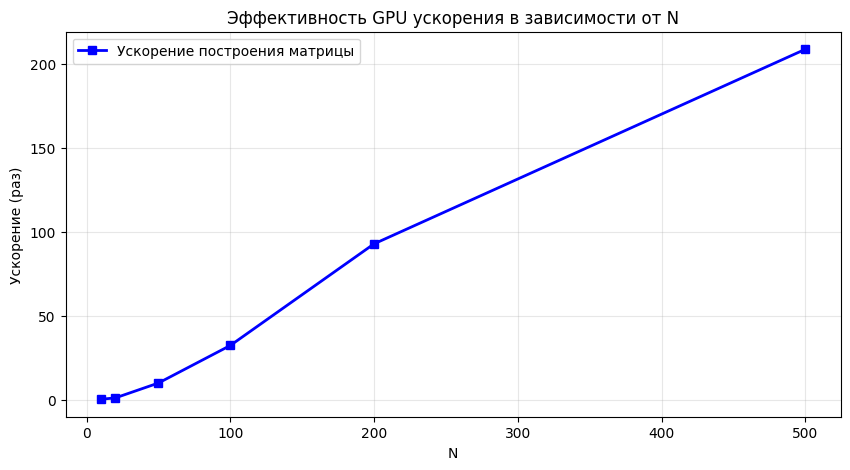

In [13]:
# Таблица значений и графики ускорения (Speedup)
if os.path.exists(results_path):
    # Фильтруем данные для N от 10 до 50
    df_filtered = df[(df['N'] >= 10) & (df['N'] <= 50)].copy()
    
    print("Значения для GPU при N от 10 до 50 (шаг 10):")
    display(df_filtered[['N', 'MatrixGPU_ms_CUDA', 'SolveTime_ms_CUDA', 'Total_ms_CUDA']])
    
    plt.figure(figsize=(10, 5))
    speedup_matrix = df['MatrixTime_ms_CPU'] / df['MatrixGPU_ms_CUDA']
    plt.plot(df['N'], speedup_matrix, 'bs-', linewidth=2, label='Ускорение построения матрицы')
    
    # Добавим вертикальные линии для диапазона 10-50
    plt.axvspan(10, 50, color='yellow', alpha=0.1, label='Диапазон N [10, 50]')
    
    plt.xlabel("N")
    plt.ylabel("Ускорение (раз)")
    plt.title("Эффективность GPU ускорения в зависимости от N")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Файл результатов не найден.")

Зависимость от числа узлов квадратуры M:


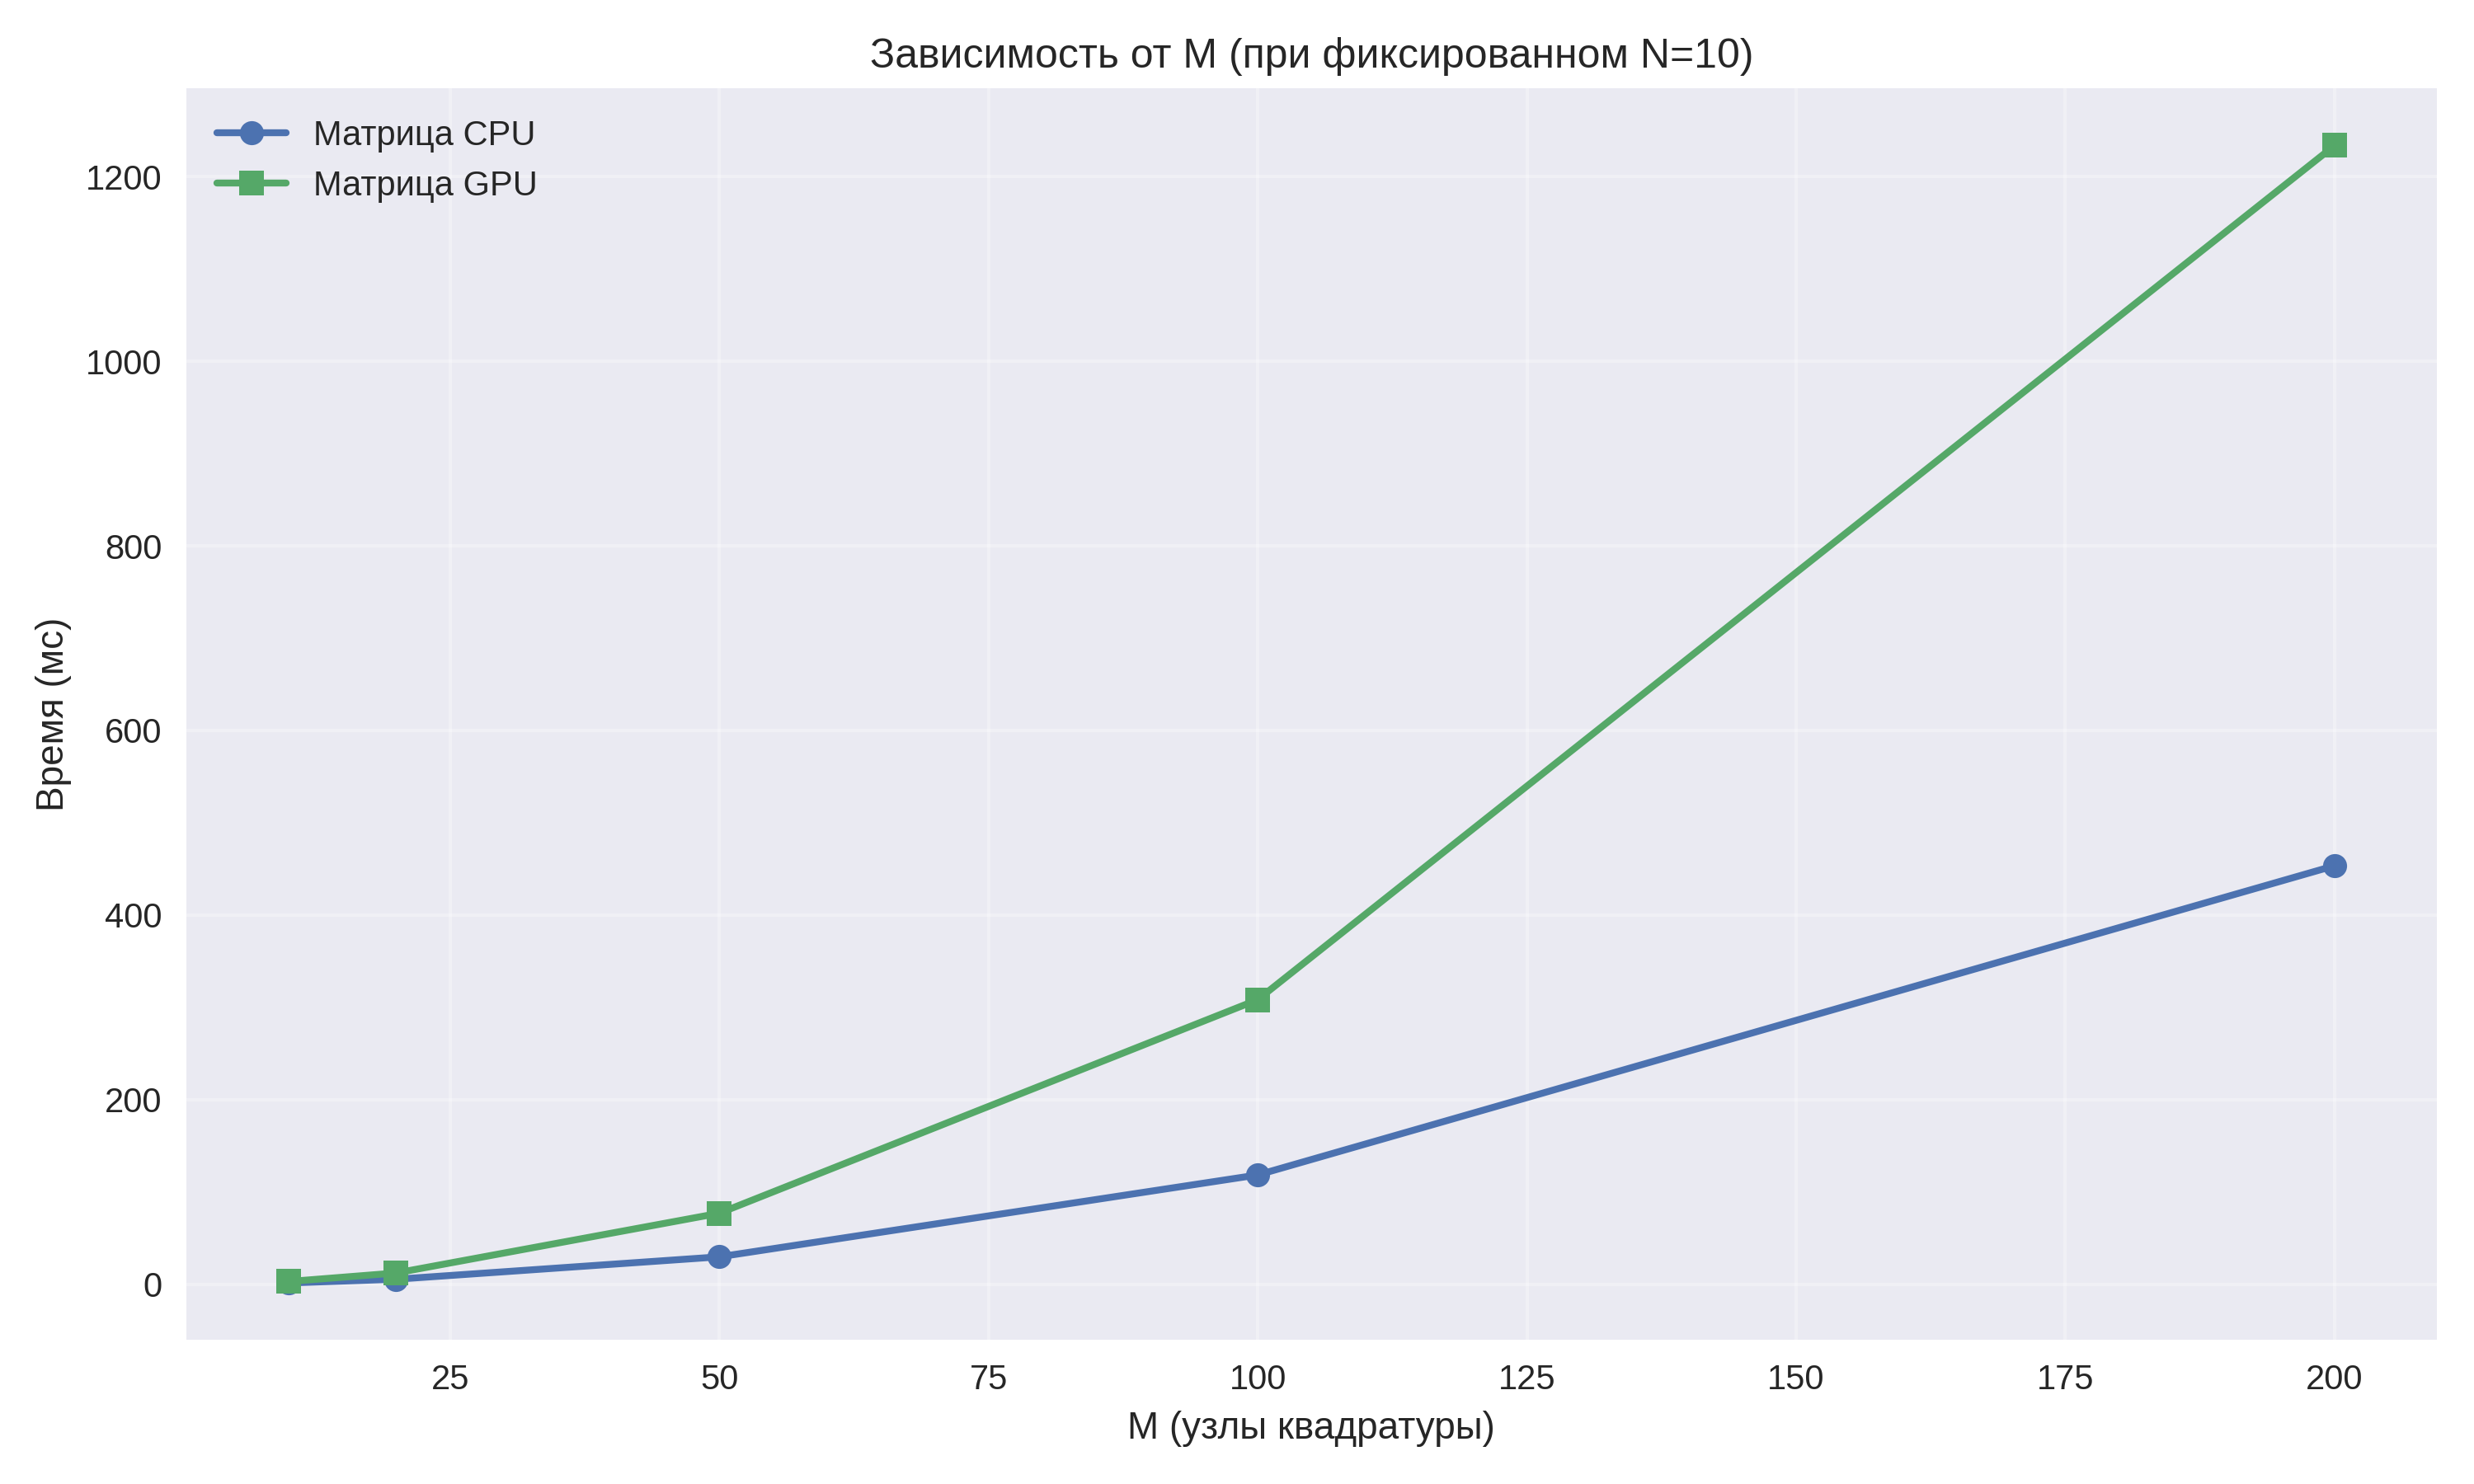

Ускорение в зависимости от M:


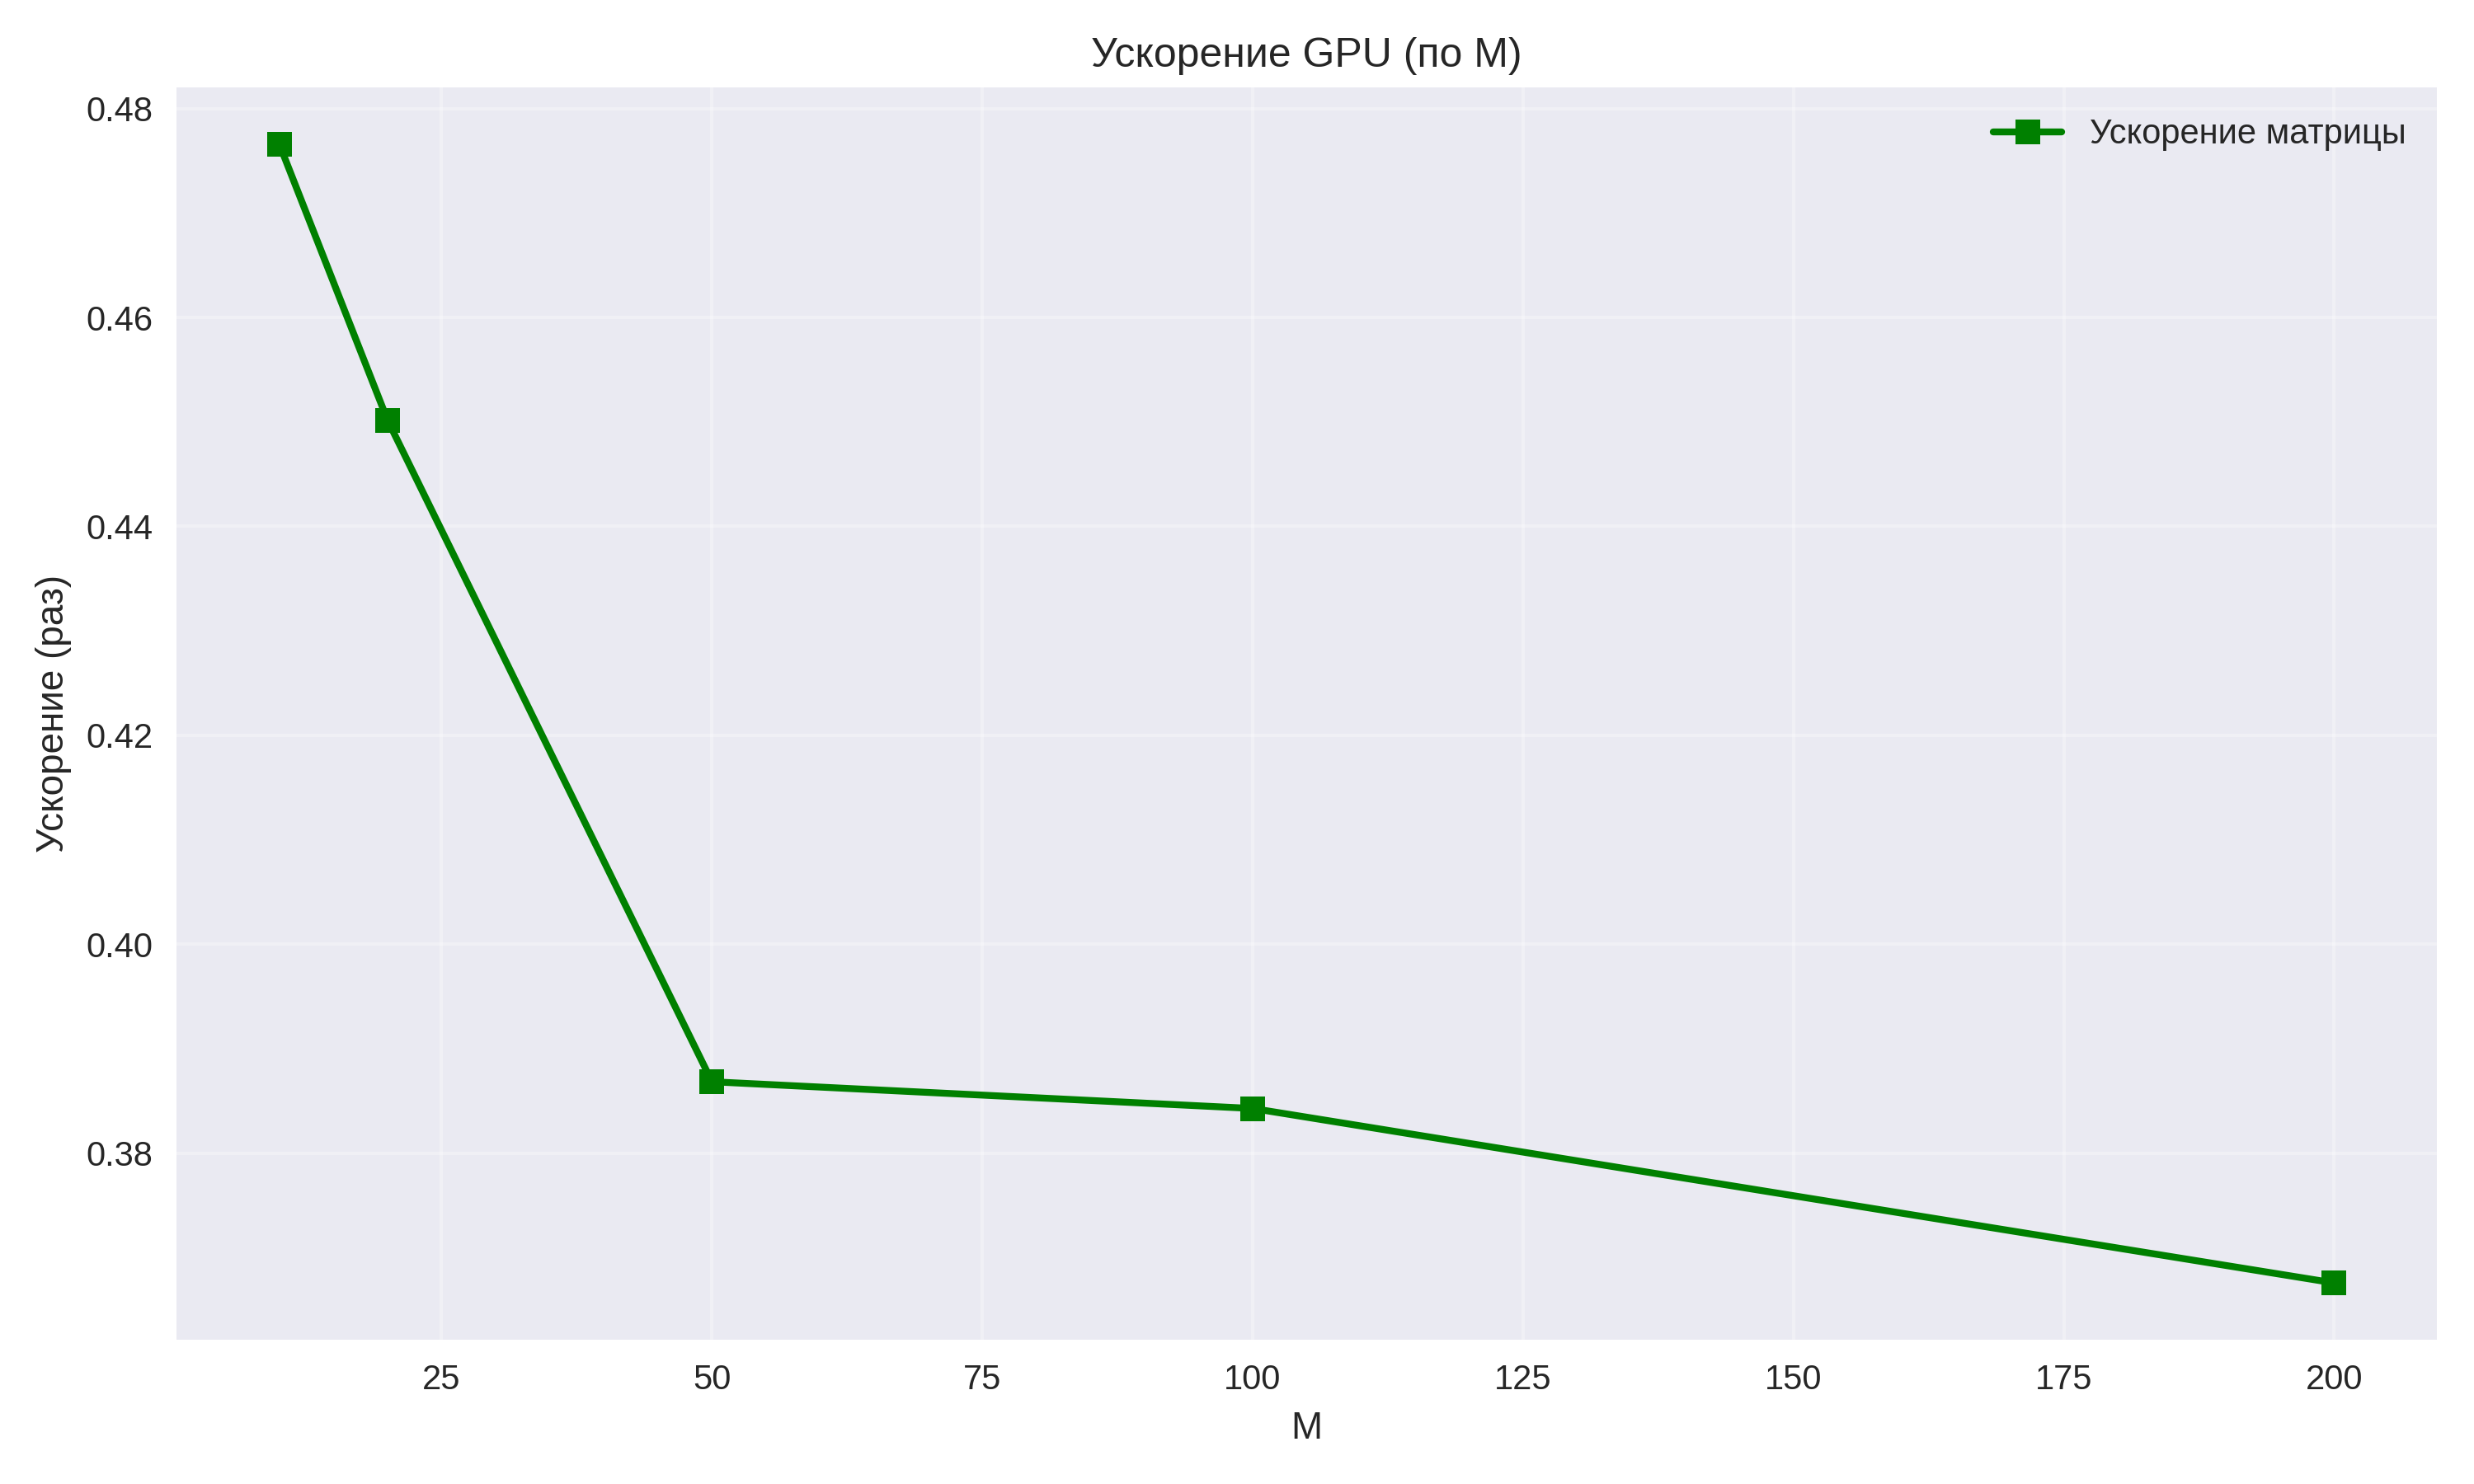

In [14]:
# Дополнительно: Зависимость от M
import glob
from IPython.display import Image, display

m_plot = 'cuda_version/plots/matrix_m_compare.png'
if os.path.exists(m_plot):
    print("Зависимость от числа узлов квадратуры M:")
    display(Image(m_plot))
    print("Ускорение в зависимости от M:")
    display(Image('cuda_version/plots/speedup_m.png'))
else:
    print("Результаты для M не найдены.")

In [ ]:
# 3D Графики сложности (N и M одновременно)
import os
from IPython.display import Image, display

plots_path = 'cuda_version/plots'
surface_cpu = os.path.join(plots_path, 'surface_3d_cpu.png')
surface_cuda = os.path.join(plots_path, 'surface_3d_cuda.png')

if os.path.exists(surface_cpu):
    print("3D Поверхность для CPU (N^2 * M^2):")
    display(Image(surface_cpu))

if os.path.exists(surface_cuda):
    print("\n3D Поверхность для CUDA (GPU ускорение):")
    display(Image(surface_cuda))